In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


file_path = 'parkinsons/parkinsons.data.csv' 
data = pd.read_csv(file_path)

X = data.drop(columns=['status', 'name'])
y = data['status']  

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in sss.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)


In [3]:
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'KSVM': SVC(kernel='rbf', probability=True, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5)  # Default k=5
}

model_results = {}

Performing Feature Selection and RandomizedSearchCV for Random Forest...
Selected Features for Random Forest: [ 0  1  2  4 10 12 13 18 19 21]
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters for Random Forest: {'bootstrap': True, 'max_depth': 33, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 186}

Random Forest Model Evaluation Metrics:
Accuracy: 0.90
Precision: 0.93
Recall: 0.93
F1 Score: 0.93
ROC AUC: 0.97

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.93      0.93      0.93        29

    accuracy                           0.90        39
   macro avg       0.87      0.87      0.87        39
weighted avg       0.90      0.90      0.90        39



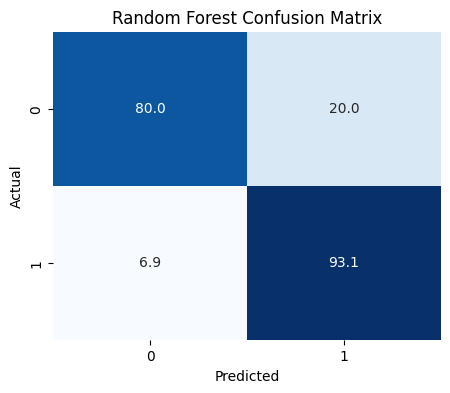

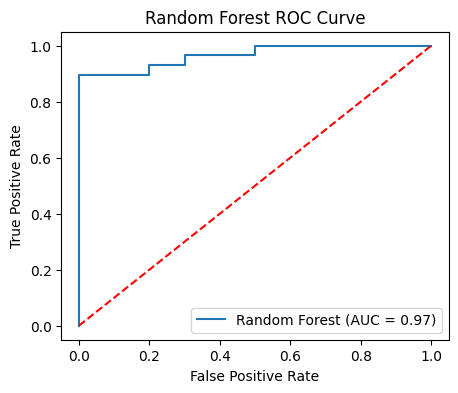

#############################################################################################
Performing Feature Selection and RandomizedSearchCV for Decision Tree...
Selected Features for Decision Tree: [ 0  1  2  4 10 12 13 14 18 21]
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 28, 'min_samples_leaf': 8, 'min_samples_split': 7}

Decision Tree Model Evaluation Metrics:
Accuracy: 0.77
Precision: 0.86
Recall: 0.83
F1 Score: 0.84
ROC AUC: 0.80

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.60      0.57        10
           1       0.86      0.83      0.84        29

    accuracy                           0.77        39
   macro avg       0.70      0.71      0.71        39
weighted avg       0.78      0.77      0.77        39



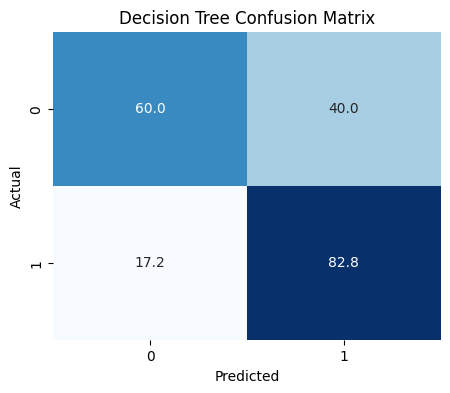

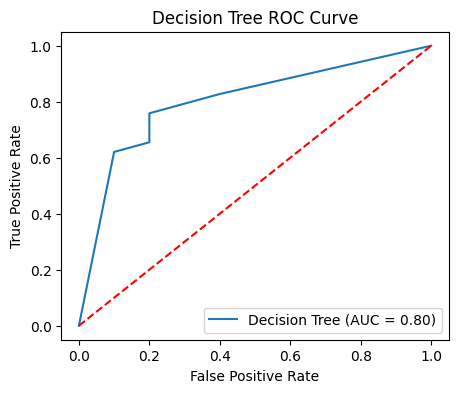

#############################################################################################
Performing Feature Selection and RandomizedSearchCV for KSVM...
Selected Features for KSVM: [ 0  1  2  4 10 12 13 14 18 21]
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters for KSVM: {'C': 9.3276479905464, 'gamma': 'scale', 'kernel': 'rbf'}

KSVM Model Evaluation Metrics:
Accuracy: 0.85
Precision: 0.96
Recall: 0.83
F1 Score: 0.89
ROC AUC: 0.94

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.90      0.75        10
           1       0.96      0.83      0.89        29

    accuracy                           0.85        39
   macro avg       0.80      0.86      0.82        39
weighted avg       0.88      0.85      0.85        39



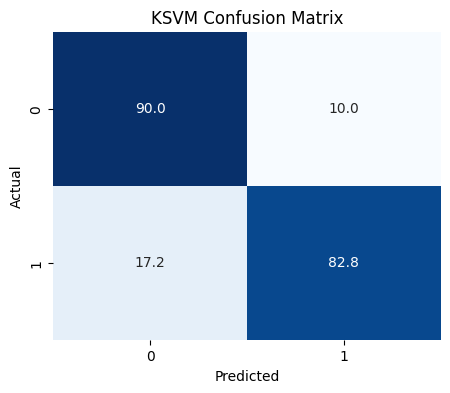

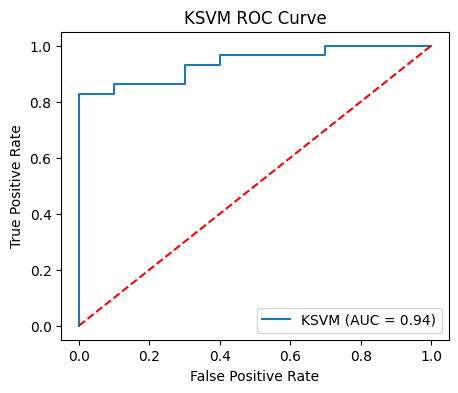

#############################################################################################
Performing Feature Selection and RandomizedSearchCV for KNN...
Selected Features for KNN: [ 0  1  2  4 10 12 13 14 18 21]
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters for KNN: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}

KNN Model Evaluation Metrics:
Accuracy: 0.92
Precision: 1.00
Recall: 0.90
F1 Score: 0.95
ROC AUC: 0.96

Classification Report:
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        10
           1       1.00      0.90      0.95        29

    accuracy                           0.92        39
   macro avg       0.88      0.95      0.91        39
weighted avg       0.94      0.92      0.93        39



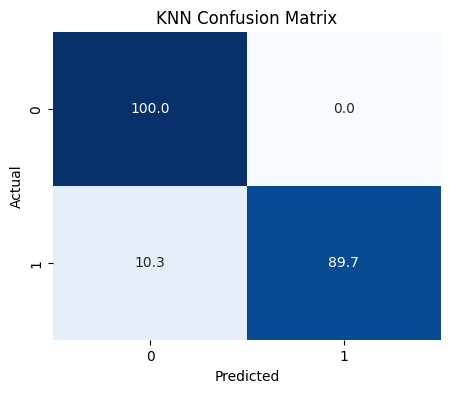

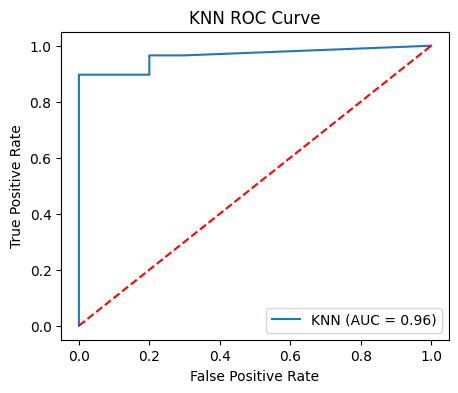

#############################################################################################


In [4]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.feature_selection import SelectKBest, mutual_info_classif

param_grids = {
    "Random Forest": {
        "n_estimators": randint(10, 300),
        "max_depth": randint(1, 50),
        "min_samples_split": randint(2, 20),
        "min_samples_leaf": randint(1, 10),
        "bootstrap": [True, False],
    },
    "Decision Tree": {
        "criterion": ["gini", "entropy"],
        "max_depth": randint(1, 50),
        "min_samples_split": randint(2, 20),
        "min_samples_leaf": randint(1, 10),
    },
    "KSVM": {
        "C": uniform(0.1, 10),
        "kernel": ["linear", "rbf", "poly", "sigmoid"],
        "gamma": ["scale", "auto"],
    },
    "KNN": {
        "n_neighbors": randint(1, 50),
        "weights": ["uniform", "distance"],
        "metric": ["euclidean", "manhattan", "minkowski"],
    },
}

def evaluate_model_with_feature_selection(name, model, param_grid, X_train_scaled, X_test_scaled, y_train_resampled, y_test):
    print(f"Performing Feature Selection and RandomizedSearchCV for {name}...")

    k_best = SelectKBest(score_func=mutual_info_classif, k=10) 
    X_train_selected = k_best.fit_transform(X_train_scaled, y_train_resampled)
    X_test_selected = k_best.transform(X_test_scaled)

    selected_features = k_best.get_support(indices=True)
    print(f"Selected Features for {name}: {selected_features}")

    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=50,  
        scoring="roc_auc", 
        cv=5, 
        verbose=2,
        random_state=40,
        n_jobs=-1,
    )
    
    random_search.fit(X_train_selected, y_train_resampled)
    
    best_model = random_search.best_estimator_
    print(f"Best Parameters for {name}: {random_search.best_params_}")

    predictions = best_model.predict(X_test_selected)
    probabilities = best_model.predict_proba(X_test_selected)[:, 1]

    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    roc_auc = roc_auc_score(y_test, probabilities)

    # Store the results
    model_results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    }

    # Display evaluation metrics
    print(f"\n{name} Model Evaluation Metrics:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"ROC AUC: {roc_auc:.2f}")
    print("\nClassification Report:")
    print(classification_report(y_test, predictions))

    # Confusion Matrix
    plt.figure(figsize=(5, 4))
    cm = confusion_matrix(y_test, predictions, normalize='true')
    sns.heatmap(cm * 100, annot=True, fmt=".1f", cmap="Blues", cbar=False)  # Convert to percentage
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, probabilities)
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="red")
    plt.title(f"{name} ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()
    print("#############################################################################################")

# Loop through models and apply feature selection and RandomizedSearchCV
for name, model in models.items():
    param_grid = param_grids.get(name)  # Get parameter grid for the specific model
    if param_grid:
        evaluate_model_with_feature_selection(name, model, param_grid, X_train_scaled, X_test_scaled, y_train_resampled, y_test)
    else:
        print(f"No parameter grid defined for {name}, skipping RandomizedSearchCV.")


Performing Feature Selection...
Selected Features: [ 0  1  2  4 10 12 13 18 19 21]
Starting RandomizedSearchCV...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Python312\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best Parameters: {'batch_size': 23, 'epochs': 97, 'model__dropout_rate': 0.1979914312095726, 'model__l2_reg': 0.0055227288910538064, 'model__learning_rate': 0.0033533033076326435}

Tuned FNN Model Evaluation Metrics:
Accuracy: 0.90
Precision: 0.96
Recall: 0.90
F1 Score: 0.93
ROC AUC: 0.96


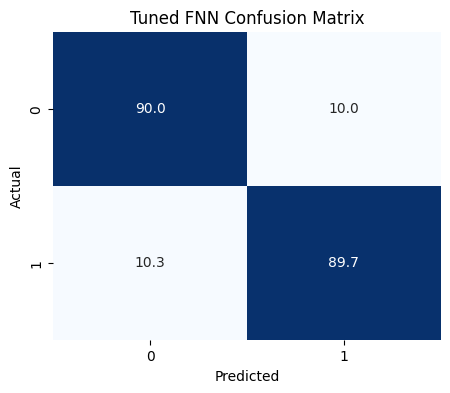

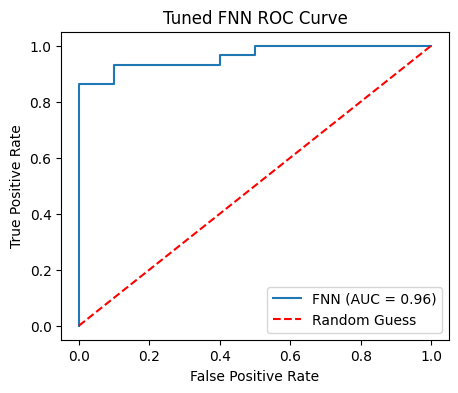

In [6]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def create_fnn(input_dim, dropout_rate=0.3, learning_rate=0.001, l2_reg=0.01):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=input_dim, kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification output
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

print("Performing Feature Selection...")
k_best = SelectKBest(score_func=mutual_info_classif, k=10)  # Select top 10 features
X_train_selected = k_best.fit_transform(X_train_scaled, y_train_resampled)
X_test_selected = k_best.transform(X_test_scaled)

selected_features = k_best.get_support(indices=True)
print(f"Selected Features: {selected_features}")

input_dim = X_train_selected.shape[1] 
fnn = KerasClassifier(
    model=create_fnn,
    input_dim=input_dim,
    epochs=50,
    batch_size=32,
    verbose=0,  
)

param_distributions = {
    "model__dropout_rate": uniform(0.1, 0.5),
    "model__learning_rate": uniform(0.0001, 0.01), 
    "model__l2_reg": uniform(0.001, 0.1), 
    "batch_size": randint(16, 64), 
    "epochs": randint(20, 100),  
}

random_search = RandomizedSearchCV(
    estimator=fnn,
    param_distributions=param_distributions,
    n_iter=20,  
    scoring="roc_auc",
    cv=5,  
    verbose=2,
    random_state=42,
    n_jobs=-1,
)

print("Starting RandomizedSearchCV...")
random_search.fit(X_train_selected, y_train_resampled)

best_fnn = random_search.best_estimator_
best_params = random_search.best_params_
print(f"Best Parameters: {best_params}")

y_pred_prob_fnn = best_fnn.predict_proba(X_test_selected)[:, 1]
y_pred_fnn = (y_pred_prob_fnn > 0.5).astype(int)

accuracy_fnn = accuracy_score(y_test, y_pred_fnn)
precision_fnn = precision_score(y_test, y_pred_fnn)
recall_fnn = recall_score(y_test, y_pred_fnn)
f1_fnn = f1_score(y_test, y_pred_fnn)
roc_auc_fnn = roc_auc_score(y_test, y_pred_prob_fnn)

# Store results
model_results["Feed Neural Network"] = {
    'Accuracy': accuracy_fnn,
    'Precision': precision_fnn,
    'Recall': recall_fnn,
    'F1 Score': f1_fnn,
    'ROC AUC': roc_auc_fnn
}

# Print metrics
print("\nTuned FNN Model Evaluation Metrics:")
print(f"Accuracy: {accuracy_fnn:.2f}")
print(f"Precision: {precision_fnn:.2f}")
print(f"Recall: {recall_fnn:.2f}")
print(f"F1 Score: {f1_fnn:.2f}")
print(f"ROC AUC: {roc_auc_fnn:.2f}")

# Confusion Matrix
plt.figure(figsize=(5, 4))
cm = confusion_matrix(y_test, y_pred_fnn, normalize='true')
sns.heatmap(cm * 100, annot=True, fmt=".1f", cmap="Blues", cbar=False)
plt.title("Tuned FNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_fnn)
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f"FNN (AUC = {roc_auc_fnn:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="red", label="Random Guess")
plt.title("Tuned FNN ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()


In [7]:
performance_df = pd.DataFrame(model_results).T
print("\nModel Performance Comparison:\n")
print(performance_df)


Model Performance Comparison:

                     Accuracy  Precision    Recall  F1 Score   ROC AUC
Random Forest        0.897436   0.931034  0.931034  0.931034  0.965517
Decision Tree        0.769231   0.857143  0.827586  0.842105  0.801724
KSVM                 0.846154   0.960000  0.827586  0.888889  0.937931
KNN                  0.923077   1.000000  0.896552  0.945455  0.963793
Feed Neural Network  0.897436   0.962963  0.896552  0.928571  0.962069


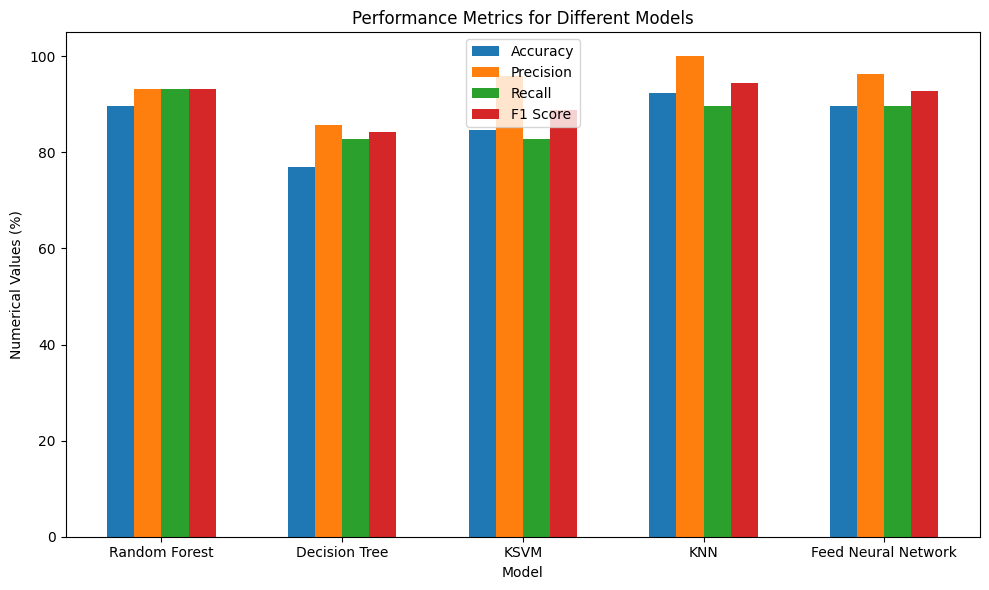

In [8]:
# Extract model names and metrics
models = list(model_results.keys())
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]

# Prepare data for plotting
values = {metric: [model_results[model][metric] * 100 for model in models] for metric in metrics}

# Plotting
x = np.arange(len(models))  # Label locations
width = 0.15  # Bar width

fig, ax = plt.subplots(figsize=(10, 6))

# Add bars for each metric
for i, metric in enumerate(metrics):
    ax.bar(x + i * width, values[metric], width, label=metric)

# Add labels, title, and legend
ax.set_xlabel("Model")
ax.set_ylabel("Numerical Values (%)")
ax.set_title("Performance Metrics for Different Models")
ax.set_xticks(x + width * (len(metrics) - 1) / 2)
ax.set_xticklabels(models)
ax.legend()

# Adjust layout and display
plt.tight_layout()
plt.show()